In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
import sys

In [2]:
#ODCZYT I ZAPIS DANYCH Z PLIKU I DO PLIKU

#Funkcja odczytująca dane z plików csv w folderze Data
def ReadData(name:str):
    df = pd.read_csv("Data/"+name,header=None, sep=' ')
    Tasks=[]
    buf=[]
    for i in range(df.shape[0]):
        buf.clear()
        buf.append(i+1)
        for j in range(df.shape[1]):
            buf.append(df.iloc[i,j].item())
        Tasks.append(buf.copy())
    return Tasks

#Funkcja zapisuje przezbrojenia do pliku
def ZapiszPrzezbrojenia(name:str, Przezbrojenia):

    df = pd.DataFrame(
                       Przezbrojenia.reshape((-1, Przezbrojenia.shape[-1])), 
                       index= pd.MultiIndex.from_product(
                          [range(Przezbrojenia.shape[0]), range(Przezbrojenia.shape[1])]
                          )
                      ).to_csv("Przezbrojenia/"+name+".csv")
    
#Funkcja wczytuje przezbrojenia z pliku
def WczytajPrzezbrojenia(name:str):
    df = pd.read_csv("Przezbrojenia/"+name+".csv", header=None, index_col=[0,1])
    Przezbrojenia = np.array(df.agg(list, 1).groupby(level=0).agg(list).tolist())
    return Przezbrojenia

    
    

In [3]:
#FUNKCJE POMOCNICZE


#Funkcja zwraca losowe czasy przezbrojen w liscie o wymiarach zaleznych od podanych w argumencie zadan
#Zwracane:
#       Przezbrojenia[ilosc maszyn]x[ilosc zadan]x[ilosc zadan]
def GenerowaniePrzezbrojen(Tasks:list):
    Przezbrojenia = np.random.randint(0,10, size=(len(Tasks[0])-1, len(Tasks), len(Tasks)))
    return Przezbrojenia

#Funckja oblicza wartosci funkcji celu dla danego zestawu testowego i odpowiednich przezbrojen
def Calc_CMax_zPrzezbrojeniami(Tasks:list, Przezbrojenia):
    C=np.zeros([len(Tasks[0])-1, len(Tasks)])
    S=np.zeros([len(Tasks[0])-1, len(Tasks)])
    #i -  maszyna, j - zadanie
    for i in range(0, len(Tasks[0])-1):
        for j in range(0, len(Tasks)):
            if j==0:
                S[i,j] = max(C[i,j-1], C[i-1,j])
            else:
                S[i,j] = max(C[i,j-1]+Przezbrojenia[i,j-1,j], C[i-1,j])
            C[i,j] = S[i,j] + Tasks[j][i+1]
    return S.transpose(), C.transpose(), C.max()
#Funkcja oblicza wartości funkcji celu dla danego zestawu zadań.
#Argumenty:
#           Tasks - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                   Pierwszy indeks oznacza numer zadania, natomiast drugi indeks 
#                   oznacza numer maszyny.
#Zwracane:
#           S     - Macierz czasów rozpoczęcia wykonywanych zadań na maszynach. 
#                   Indeksowana w sposób S[zadanie][maszyna]
#           C     - Macierz czasów zakończenia wykonywanych zadań na maszynach. 
#                   Indeksowana w sposób C[zadanie][maszyna]
#           Cmax  - Maksymalny czas wykonywania wszystkich zadań.
#Funkcja przy liczeniu pomija pierwszy element każdego wektora czasów zadań, ponieważ jest on
#zarezerwowany dla numeru zadania.
def Calc_CMax(Tasks:list):
    C=np.zeros([len(Tasks[0])-1, len(Tasks)])
    S=np.zeros([len(Tasks[0])-1, len(Tasks)])
    #i -  maszyna, j - zadanie
    for i in range(0, len(Tasks[0])-1):
        for j in range(0, len(Tasks)):
            S[i,j] = max(C[i,j-1], C[i-1,j])
            C[i,j] = S[i,j] + Tasks[j][i+1]
    return S.transpose(), C.transpose(), C.max()

#Funkcja zamienia miejscami 2 elementy listy
#Argumenty:
#           Tasks - Lista z elementami. !!!Podając liste do funkcji należy użyc metody copy()
#           i, j  - Pozycje zamienianych argumentów na liście.
#Zwracane:
#           Tasks - Lista z zamienionymi elementami.
def Swap(Tasks:list, i:int, j:int):
    buffer1=Tasks[i]
    buffer2=Tasks[j]
    Tasks[i]=buffer2
    Tasks[j]=buffer1
    return Tasks


#Funkcja wyciągająca i-ty element listy i ustawiająca go na j-tej pozycji.
#Argumenty:
#           Tasks - Lista z elementami. !!!Podając liste do funkcji należy użyc metody copy()
#           i, j  - Pozycje zamienianych argumentów na liście.
#Zwracane:
#           bufList - Lista z zamienionymi elementami.
def Swap2(Tasks:list, i:int, j:int):  
    bufList=[]
    if i<j:
        l=j+1
    else:
        l=j
    for k in range(0, l):
        if (k is not i):
            bufList.append(Tasks[k])
    bufList.append(Tasks[i])
    for k in range(l, len(Tasks)):
        if (k is not i):
            bufList.append(Tasks[k])
    return bufList
    

#Funkcja służąca do zmniejszania zakazów na liście Tabu zrealizowanej w formie macierzy.
#Jej działanie polega na zmniejszeniu o jeden wartości większy od zera, co oznacza skrócenie
#zakazu danego ruchu.
#Argumenty:
#           Tabu - Macierz reprezentująca listę zakazów.
#Zwracane:
#           Tabu - Macierz zakazów ze zmniejszonymi ograniczeniami.
def TabuDecrement(Tabu):
    for i in range(Tabu.shape[0]):
        for j in range(Tabu.shape[1]):
            if Tabu[i,j] != 0:
                Tabu[i,j] += -1
    return Tabu

#Funkcja wyświetla permutację zadań (kolejność wykonywania zadań)
def PrintPermutation(Tasks:list):
    buffer=[]
    for i in range(len(Tasks)):
        buffer.append(Tasks[i][0]-1)
    print(buffer)




In [4]:
#ALGORTYM NEH

#Funkcja pomocnicza dla algorytmu NEH. Ma zadanie obliczanie wag zadań, 
#czyli sumy czasów wykonywania zadania na wszystkich maszynach.
#Argumenty:
#       Tasks       - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                     Indeksowanie takie samo jak przy pozostałych algorytmach.
#Zwraca:
#        weights    - Lista wag zadań (kolejność taka sama jak dla zadań).
def CalculateWeights(Tasks:list):
    weights=[]
    for i in range(len(Tasks)):
        weights.append(np.array(Tasks[i][1:]).sum())
    return weights

#Funkcja za ma zadanie dodanie do aktualnej permutacji nowe zadanie w taki sposób,
# że wartość funkcji celu dla nowej permutacji będzie jak najmniejsza.
#Argumenty:
#       Tasks       - Aktualna permutacja
#       NewTasks    - Nowe zadanie
#Zwraca:
#       permutation - Znaleziona najlepsza permutacja
def FindBestPosition(Tasks:list, NewTask:list):
    permutation=[]
    bestPermutation=[]
    CMax=float('inf')
    bestCMax=float('inf')
    
    #Sprawdzenie każdej dowolnej pozycji
    for i in range(len(Tasks)+1):
        permutation.clear()
        
        #Utworzenie permutacji z zadaniem dodanym na konkretnej pozycji
        for j in range(len(Tasks)):
            if j==i:
                permutation.append(NewTask.copy())
            permutation.append(Tasks[j].copy())
        #WYJĄTEK nowe zadanie na końcu permutacji
        if i == (len(Tasks)):
            permutation.append(NewTask.copy())
        
        #Obliczenie wartości funkcji celu nowej permutacji
        S, C, CMax=Calc_CMax(permutation.copy())
        #Zapamiętanie najlpeszego rozwiązania
        if CMax < bestCMax:
            bestCMax=CMax
            bestPermutation=permutation.copy()
    
    return bestPermutation
  
#Implementacja algorytmu NEH, który ma za zadanie znalezienie jak najlepszej 
# permutacji wykonywania zadań dla problemu przepływowego.
#Argumenty:
#       Tasks       - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                     Pierwszy indeks oznacza numer zadania, natomiast drugi indeks 
#                     oznacza numer maszyny (wyjątek: pierwszy element każdego zadania to jego numer,
#                     a nie czas wykonywania na pierwszej maszynie).
#Zwraca:
#       permutation - Znaleziona permutacja.
def NEH(Tasks:list):
    permutation=[]
    #Obliczenie wag zadań
    listOfWeights=CalculateWeights(Tasks.copy())      
    
    #Sortowanie zadań
    zippedTasks = sorted(zip(listOfWeights, Tasks.copy()), key=lambda x: x[0], reverse=True)
    
    #Tworzenie najlepszej permutacji
    permutation.append(zippedTasks[0][1])
    for i in range(1, len(zippedTasks)):
        permutation=FindBestPosition(permutation.copy(), zippedTasks[i][1].copy())

    return permutation

In [5]:
#ALGORYTM TABU SEARCH

# Pierwsza wersja algortymu tabu search. Zaimplementowano w niej listę zakazów (w postaci macierzy) 
# oraz funkcję aspiracji w postaci akceptowania zakazanego ruchu, gdy da on lepszą permutancję niż 
# aktualnie najlepsza.
# Argumenty:
#           Tasks           - Czasy wykonywania zadań reprezentowane przez listę dwuwymiarową.
#                           Pierwszy indeks oznacza numer zadania, natomiast drugi indeks 
#                           oznacza numer maszyny (wyjątek: pierwszy element każdego zadania to jego numer,
#                           a nie czas wykonywania na pierwszej maszynie).
#           epochs_max      - Maksymalna liczba powtórzeń algorytmu.
#           tabuValue       - Długość listy zakazów. Wartość definiuje przez ile kolejnych 
#                           przeszukiwań dany ruch będzie zakazany.
#           stopRepeat      - Liczba powtórzeń poszukiwań, po której algorytm zostanie zatrzymany, 
#                           gdy nie zostanie znalezione lepsze rozwiązanie.
#           aspiration      - Dla wartości True działa funkcja aspiracji.
#           neighboursType  - Metoda generowania sąsiedztwa:
#                               *1 - Metoda par dowolnych
#                               *2 - Metoda par przyległych
#                               *3 - Technika przenoszenia i wstawiania
# Zwracane:
#           bestPermutation - Najlepsza znaleziona permutacja, która daje możliwe 
#                             jak najniższą wartość funkcji celu.
#           cmax_epochs     - Lista wartości funkcji celu cmax dla permutacji zadań znalezionych w każdej z epok.
def TabuSearch(Tasks:list, epochs_max:int, tabuValue=7, stopRepeat=25, aspiration=False, neighboursType=1):

    
    #Inicjalizacja zmiennych
    tabu=np.zeros([len(Tasks), len(Tasks)])
    permutation=NEH(Tasks.copy())
    S, C, cmax = Calc_CMax(permutation.copy())
    bestPermutation=permutation.copy()
    bestCMax= cmax
    neighbours=[]
    repeat=0
    nn=0
    cmax_epochs=[]

    
    #Warunek stopu
    for n in range(epochs_max):
        repeat+=1
        
        #Zmniejszenie zakazów
        tabu = TabuDecrement(tabu)
        
        #Generowanie sąsiadów
        neighbours.clear()
        for i in range(len(Tasks)):
        
            #Wymiana par dowolnych
            if neighboursType == 1:
                for j in range(i+1, len(Tasks)):
                    bufPermutation=Swap(permutation.copy(), i, j)
                    empty1, empty2, cmax=Calc_CMax(bufPermutation.copy())
                    buf=[i, j, cmax]
                    neighbours.append(buf.copy())
            
                        
            #Wymiana par przyległych
            if neighboursType == 2:
                if i < len(Tasks)-1:
                    bufPermutation=Swap(permutation.copy(), i, i+1)
                    empty1, empty2, cmax=Calc_CMax(bufPermutation.copy())
                    buf=[i, i+1, cmax]
                    neighbours.append(buf.copy())
                    
            #Technika przenoszenia i wstawiania
            if neighboursType == 3:
                for j in range(len(Tasks)):
                    if(i is not j) & (i is not j+1):
                        bufPermutation=Swap2(permutation.copy(), i, j)
                        empty1, empty2, cmax=Calc_CMax(bufPermutation.copy())
                        buf=[i, j, cmax]
                        neighbours.append(buf.copy())
                    
                    
        #Sortowanie sąsiadów 
        neighbours=sorted(neighbours, key=lambda x: x[2])
        
        
        #Sprawdzanie listy tabu
        for k in range(len(neighbours)):
            a, b, cmax = neighbours[k]
            #Przeliczenie pozycji na liście na numery zadań
            i = permutation[a][0]-1
            j = permutation[b][0]-1
            #Wybór dozwolonego ruchu
            if tabu[i,j]==0:
                #Dla metód wymiany par dowolonych i wymiany par przyległych operacje swap(i,j) i swap(j,i) są równoważne,
                #a nałożenie operacji swap(i,j) na wynik operacji(i,j) znosi działanie operacji i tworzony jest cykl.
                #Dlatego należy zakazać operacji swap(i,j) i swap(j,i) po wykonaniu operacji(i,j)
                if (neighboursType == 1) | (neighboursType == 2):
                    tabu[i,j]=tabuValue
                    tabu[j,i]=tabuValue
                #Dla techniki przenoszenia i wstawianie operacje swap(i,j) i swap(j,i) nie są równoważne i dają różne efekty,
                #jednak nałożenie operacji swap(j,i) na wynik operacji swap(i,j), znosi działanie pierwotnie wykonanej operacji,
                #co powoduje utworzeniu cyklu. Z tego powodu po wykonaniu operacji swap(i,j) należy zakazać wykonania operacji
                #swap(j,i). Wyjątkiem od tej reguły jest przypadek gdy j=i+1 lub j=i-1. W tym przypadku swap(i,j) jest równoważne
                #operacji swap(j,i), a więc w tym przypadku należy zabronić wykania obu operacji.
                if (neighboursType == 3):
                    tabu[j,i]=tabuValue
                    if abs(a-b) == 1:
                        tabu[i,j]=tabuValue
                #Wymiana par dowolnych lub par przyległych
                if (neighboursType == 1) | (neighboursType == 2):
                    permutation=Swap(permutation.copy(), a, b)
                #Technika przenoszenia i wstawiania
                if neighboursType == 3:
                    permutation=Swap2(permutation.copy(), a, b)
                if cmax<bestCMax:
                    bestCMax=cmax
                    bestPermutation=permutation.copy()
                    repeat=0
                break
            #Aspiracja - wykonujemy zakazany ruch, gdy da rozwiązanie lepsze niż najlepsze aktualnie znalezione
            elif cmax<bestCMax:
                if aspiration:
                    if (neighboursType == 1) | (neighboursType == 2):
                        tabu[i,j]=tabuValue
                        tabu[j,i]=tabuValue
                    if (neighboursType == 3):
                        tabu[j,i]=tabuValue
                        if abs(a-b) == 1:
                            tabu[i,j]=tabuValue
                    #Wymiana par dowolnych lub par przyległych
                    if (neighboursType == 1) | (neighboursType == 2):
                        permutation=Swap(permutation.copy(), a, b)
                    #Technika przenoszenia i wstawiania
                    if neighboursType == 3:
                        permutation=Swap2(permutation.copy(), a, b)
                    bestCMax=cmax
                    bestPermutation=permutation.copy()
                    repeat=0
                    break
        cmax_epochs.append(cmax)
        #Sprawdzenie czy permutacja się powtarza
        
        if repeat==stopRepeat:
            nn=n+1
            break
        
    #MOŻLIWE SPOSOBY KOŃCZENIA ALGORYTMU
    #-Określona liczba powtórzeń
    #-Zakończenie gdy znajdowana wartość funkcji celu się powtarza (średnio działa dla tego problemu)
    #-Kończenie gdy przez N powtórzeń nie znajdzie się lepsze rozwiązanie (Aktualnie zaimplementowane)
        
        
    #Zwrócenie najlepszego rozwiązania
    return bestPermutation.copy() , cmax_epochs #,nn





In [6]:
#TABUSEARCH DLA PROBLEMU Z PRZEZBROJENIAMI
def TabuSearch_przezbrojenia(Tasks:list, Przezbrojenia, epochs_max:int, tabuValue=7, stopRepeat=25, aspiration=False, neighboursType=1):

    
    #Inicjalizacja zmiennych
    tabu=np.zeros([len(Tasks), len(Tasks)])
    permutation=NEH(Tasks.copy())
    S, C, cmax = Calc_CMax_zPrzezbrojeniami(permutation.copy(), Przezbrojenia)
    bestPermutation=permutation.copy()
    bestCMax= cmax
    neighbours=[]
    repeat=0
    nn=0
    cmax_epochs=[]

    
    #Warunek stopu
    for n in range(epochs_max):
        repeat+=1
        
        #Zmniejszenie zakazów
        tabu = TabuDecrement(tabu)
        
        #Generowanie sąsiadów
        neighbours.clear()
        for i in range(len(Tasks)):
        
            #Wymiana par dowolnych
            if neighboursType == 1:
                for j in range(i+1, len(Tasks)):
                    bufPermutation=Swap(permutation.copy(), i, j)
                    empty1, empty2, cmax=Calc_CMax_zPrzezbrojeniami(permutation.copy(), Przezbrojenia)
                    buf=[i, j, cmax]
                    neighbours.append(buf.copy())
            
                        
            #Wymiana par przyległych
            if neighboursType == 2:
                if i < len(Tasks)-1:
                    bufPermutation=Swap(permutation.copy(), i, i+1)
                    empty1, empty2, cmax=Calc_CMax_zPrzezbrojeniami(permutation.copy(), Przezbrojenia)
                    buf=[i, i+1, cmax]
                    neighbours.append(buf.copy())
                    
            #Technika przenoszenia i wstawiania
            if neighboursType == 3:
                for j in range(len(Tasks)):
                    if(i is not j) & (i is not j+1):
                        bufPermutation=Swap2(permutation.copy(), i, j)
                        empty1, empty2, cmax=Calc_CMax_zPrzezbrojeniami(permutation.copy(), Przezbrojenia)
                        buf=[i, j, cmax]
                        neighbours.append(buf.copy())
                    
                    
        #Sortowanie sąsiadów 
        neighbours=sorted(neighbours, key=lambda x: x[2])
        
        
        #Sprawdzanie listy tabu
        for k in range(len(neighbours)):
            a, b, cmax = neighbours[k]
            #Przeliczenie pozycji na liście na numery zadań
            i = permutation[a][0]-1
            j = permutation[b][0]-1
            #Wybór dozwolonego ruchu
            if tabu[i,j]==0:
                #Dla metód wymiany par dowolonych i wymiany par przyległych operacje swap(i,j) i swap(j,i) są równoważne,
                #a nałożenie operacji swap(i,j) na wynik operacji(i,j) znosi działanie operacji i tworzony jest cykl.
                #Dlatego należy zakazać operacji swap(i,j) i swap(j,i) po wykonaniu operacji(i,j)
                if (neighboursType == 1) | (neighboursType == 2):
                    tabu[i,j]=tabuValue
                    tabu[j,i]=tabuValue
                #Dla techniki przenoszenia i wstawianie operacje swap(i,j) i swap(j,i) nie są równoważne i dają różne efekty,
                #jednak nałożenie operacji swap(j,i) na wynik operacji swap(i,j), znosi działanie pierwotnie wykonanej operacji,
                #co powoduje utworzeniu cyklu. Z tego powodu po wykonaniu operacji swap(i,j) należy zakazać wykonania operacji
                #swap(j,i). Wyjątkiem od tej reguły jest przypadek gdy j=i+1 lub j=i-1. W tym przypadku swap(i,j) jest równoważne
                #operacji swap(j,i), a więc w tym przypadku należy zabronić wykania obu operacji.
                if (neighboursType == 3):
                    tabu[j,i]=tabuValue
                    if abs(a-b) == 1:
                        tabu[i,j]=tabuValue
                #Wymiana par dowolnych lub par przyległych
                if (neighboursType == 1) | (neighboursType == 2):
                    permutation=Swap(permutation.copy(), a, b)
                #Technika przenoszenia i wstawiania
                if neighboursType == 3:
                    permutation=Swap2(permutation.copy(), a, b)
                if cmax<bestCMax:
                    bestCMax=cmax
                    bestPermutation=permutation.copy()
                    repeat=0
                break
            #Aspiracja - wykonujemy zakazany ruch, gdy da rozwiązanie lepsze niż najlepsze aktualnie znalezione
            elif cmax<bestCMax:
                if aspiration:
                    if (neighboursType == 1) | (neighboursType == 2):
                        tabu[i,j]=tabuValue
                        tabu[j,i]=tabuValue
                    if (neighboursType == 3):
                        tabu[j,i]=tabuValue
                        if abs(a-b) == 1:
                            tabu[i,j]=tabuValue
                    #Wymiana par dowolnych lub par przyległych
                    if (neighboursType == 1) | (neighboursType == 2):
                        permutation=Swap(permutation.copy(), a, b)
                    #Technika przenoszenia i wstawiania
                    if neighboursType == 3:
                        permutation=Swap2(permutation.copy(), a, b)
                    bestCMax=cmax
                    bestPermutation=permutation.copy()
                    repeat=0
                    break
        cmax_epochs.append(cmax)
        #Sprawdzenie czy permutacja się powtarza
        
        if repeat==stopRepeat:
            nn=n+1
            break
        
    #MOŻLIWE SPOSOBY KOŃCZENIA ALGORYTMU
    #-Określona liczba powtórzeń
    #-Zakończenie gdy znajdowana wartość funkcji celu się powtarza (średnio działa dla tego problemu)
    #-Kończenie gdy przez N powtórzeń nie znajdzie się lepsze rozwiązanie (Aktualnie zaimplementowane)
        
        
    #Zwrócenie najlepszego rozwiązania
    return bestPermutation.copy() , cmax_epochs #,nn

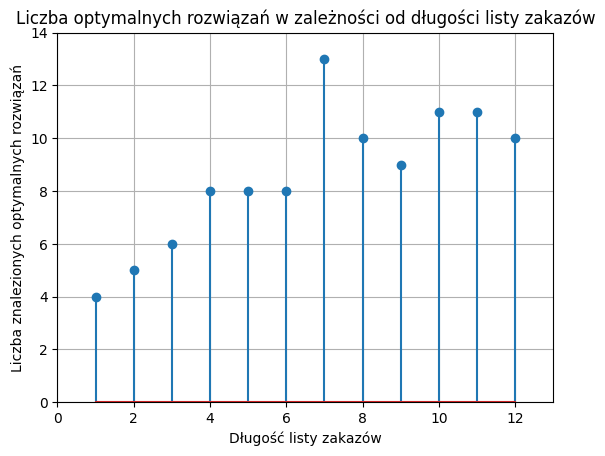

In [48]:
#BADANIE 1
#DOBÓR DŁUGOŚCI LISTY TABU
#Badanie ma na celu znalezienie jak najlepszej długości listy zakazu. 
# Na potrzeby tego wyłączono działanie funkcji aspiracji oraz ustalono liczbę powtórzen alogrytmu
'''
epochs=100
tabuValue= np.arange(12)+1
csv_file = open('Badania1.csv', 'w')
for i in range(1, 23):
    data = ReadData("data."+str(i))
    print("Przetwarzanie pliku data."+str(i))
    perm = NEH(data)
    S, C, cmax = Calc_CMax(perm)
    results = str(cmax)
    print("Algorytm NEH: Cmax="+str(cmax))
    for j in range(len(tabuValue)):
        perm = TabuSearch(data, 100, tabuValue[j], 0)
        S, C, cmax = Calc_CMax(perm)
        results += " "+str(cmax)
        print("Algorytm TabuSearch przy liście tabu o długości="+str(tabuValue[j])+" : Cmax="+str(cmax))
    csv_file.writelines(results+"\n")
    print(results)

csv_file.close()
'''

#WYNIK BADAŃ NAJLEPSZE EFEKTY DLA LISTY TABU O DŁUGOŚCI 7

result1 = [4,5,6,8,8,8,13,10,9,11,11,10]
plt.figure()
plt.stem(range(1,len(result1)+1), result1)
plt.xlabel("Długość listy zakazów")
plt.ylabel("Liczba znalezionych optymalnych rozwiązań")
plt.title("Liczba optymalnych rozwiązań w zależności od długości listy zakazów")
plt.axis([0,13,0,14])
plt.grid()




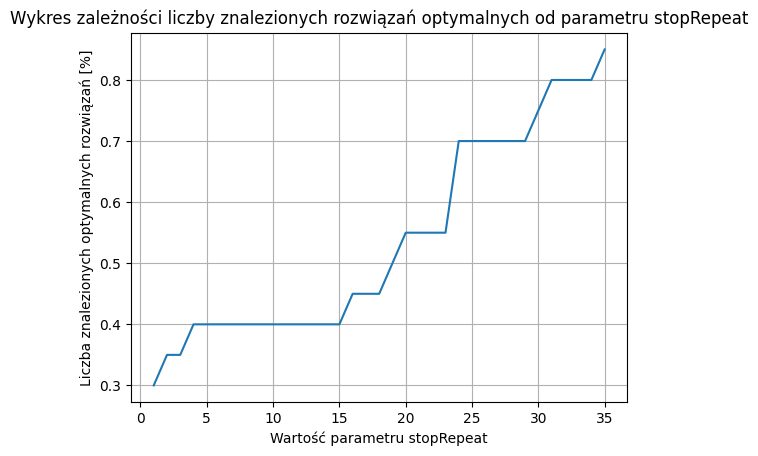

In [49]:
#BADANIE 2
#DOBÓR LICZBY POWTÓRZEŃ ALGORYTMU
#Badanie ma na celu wyznaczenie optymalnej wartości liczby powtórzeń algorytmu. 
# Pierwszą opcją jest z góry ustalona liczba powtórzeń, jednak jej minusem jest 
# trudność w oszacowaniu odpowiedniej liczby dla zestawu danych. Innym warunkiem 
# stopu może być brak znalezienia lepszego rozwiązania od dotychczasowego przez N 
# powtórzeń. W tym celu w tym badaniu sprawdzono jakie wartości N są najlepsze do 
# posiadanych zestawów danych. Podczas badania korzystano z wcześniej wyznaczonej 
# długości listy tabu i jednocześnie nie korzystano z funkcji aspiracji.

'''
epochs=1000
tabuValue=7
N= np.arange(36)+1

csv_file = open('Badania2.csv', 'w')
for i in range(1, 21):
    data = ReadData("data."+str(i))
    print("Przetwarzanie pliku data."+str(i))
    perm = NEH(data)
    S, C, cmax = Calc_CMax(perm)
    results = str(cmax)
    print("Algorytm NEH: Cmax="+str(cmax))
    for j in range(len(N)):
        perm, n= TabuSearch(data, epochs, tabuValue, N[j])
        S, C, cmax = Calc_CMax(perm)
        results += " "+str(cmax)+" "+str(n)
        print("Algorytm TabuSearch przy N="+str(N[j])+" : Cmax="+str(cmax)+" n= "+str(n))
    csv_file.writelines(results+"\n")
    print(results)

csv_file.close()
'''

#WYNIK BADAŃ: Najlepiej przyjmować liczbę powtórzeń algortmu >25

result2=[6,7,7,8,8,8,8,8,8,8,8,8,8,8,8,9,9,9,10,11,11,11,11,14,14,14,14,14,14,15,16,16,16,16,17]
result2=[i/20.0 for i in result2]
plt.figure()
plt.plot(range(1,len(result2)+1), result2)
plt.xlabel("Wartość parametru stopRepeat")
plt.ylabel("Liczba znalezionych optymalnych rozwiązań [%]")
plt.title("Wykres zależności liczby znalezionych rozwiązań optymalnych od parametru stopRepeat")
#plt.axis([0,13,0,14])
plt.grid()



In [50]:
#BADANIE 3
#PORÓWNANIE WPŁYWU FUNKCJI ASPIRACJI
#1 - aspiracja
#2 - bez aspiracji
'''
max_epochs=100
tabuValue= 7
epochs=25
buffer1=[]
buffer2=[]
for i in range(1, 11):
    data = ReadData("data."+str(i))
    buffer1.clear()
    buffer2.clear()
    perm, buffer1 = TabuSearch(data, max_epochs, tabuValue, epochs, True)
    perm, buffer2 = TabuSearch(data, max_epochs, tabuValue, epochs, False)
    plt.figure()
    plt.plot(range(1,len(buffer1)+1), buffer1)
    plt.plot(range(1,len(buffer2)+1), buffer2, linestyle='--')
    plt.title("Badanie wpływu funkcji aspiracji na działanie algorytmu")
    plt.legend(["Algorytm z aspiracją", "Algorytm bez aspiracji"])
    plt.xlabel("Liczba powtórzeń algorytmu")
    plt.ylabel("Wartość funkcji celu cmax")
    plt.grid()
    plt.show()
'''


'\nmax_epochs=100\ntabuValue= 7\nepochs=25\nbuffer1=[]\nbuffer2=[]\nfor i in range(1, 11):\n    data = ReadData("data."+str(i))\n    buffer1.clear()\n    buffer2.clear()\n    perm, buffer1 = TabuSearch(data, max_epochs, tabuValue, epochs, True)\n    perm, buffer2 = TabuSearch(data, max_epochs, tabuValue, epochs, False)\n    plt.figure()\n    plt.plot(range(1,len(buffer1)+1), buffer1)\n    plt.plot(range(1,len(buffer2)+1), buffer2, linestyle=\'--\')\n    plt.title("Badanie wpływu funkcji aspiracji na działanie algorytmu")\n    plt.legend(["Algorytm z aspiracją", "Algorytm bez aspiracji"])\n    plt.xlabel("Liczba powtórzeń algorytmu")\n    plt.ylabel("Wartość funkcji celu cmax")\n    plt.grid()\n    plt.show()\n'

In [51]:
#BADANIE 4
#PORÓWNANIE METOD GENEROWANIA SASIĘDZTWA
#Badanie ma na celu porównanie jak na proces poszukiwania minimum lokalnego wpływają znane metody tworzenia sąsiedztwa. 
# Podczas badania mierzona będzie wartość funkcji celu dla permutacji wyznaczonej w każdej epoce oraz czas wykonywania algorytmu. 
# Dzięki temu będzie można określić, które metoda pozwala na osiągnięcie najlpszych wyników w jak najkrótszym czasie
'''

max_epochs=100
tabuValue=7
epochs=25
N=[1,2,3]
cmax=[]

csv_file = open('Badania4.csv', 'w')
for i in range(1, 21):
    data = ReadData("data."+str(i))
    print("Przetwarzanie pliku data."+str(i))
    perm = NEH(data)
    S, C, CMax = Calc_CMax(perm)
    results = str(CMax)
    print("Algorytm NEH: Cmax="+str(CMax))
    cmax.clear()
    for j in range(len(N)):
        start = time.time()
        perm, buf= TabuSearch(data, max_epochs, tabuValue, epochs, aspiration=False ,neighboursType=N[j])
        end = time.time()
        S, C, CMax = Calc_CMax(perm)
        cmax.append(buf)
        results += " "+str(CMax)+" "+str(end-start)
        print("Algorytm TabuSearch przy type sąsiedztwa nr="+str(N[j])+" : Cmax="+str(CMax)+", Czas wykonywania algorytmu: "+str(end-start)+"s")
    csv_file.writelines(results+"\n")
    plt.figure()
    plt.plot(range(1,len(cmax[0])+1), cmax[0], 'r')
    plt.plot(range(1,len(cmax[1])+1), cmax[1], 'g--')
    plt.plot(range(1,len(cmax[2])+1), cmax[2], 'b--')
    plt.title("Badanie wpływu metody generowania sąsiedztwa na działanie algorytmu bez funckji aspiracji")
    plt.legend(["Metoda wymiany par dowolnych", "Metoda wymiany par przyległych", "Technika przenoszenia i wstawiania"])
    plt.xlabel("Liczba powtórzeń algorytmu")
    plt.ylabel("Wartość funkcji celu cmax")
    plt.grid()
    plt.show()

csv_file.close()
'''

'\n\nmax_epochs=100\ntabuValue=7\nepochs=25\nN=[1,2,3]\ncmax=[]\n\ncsv_file = open(\'Badania4-1.csv\', \'w\')\nfor i in range(1, 21):\n    data = ReadData("data."+str(i))\n    print("Przetwarzanie pliku data."+str(i))\n    perm = NEH(data)\n    S, C, CMax = Calc_CMax(perm)\n    results = str(cmax)\n    print("Algorytm NEH: Cmax="+str(CMax))\n    cmax.clear()\n    for j in range(len(N)):\n        start = time.time()\n        perm, buf= TabuSearch(data, max_epochs, tabuValue, epochs, aspiration=True ,neighboursType=N[j])\n        end = time.time()\n        S, C, CMax = Calc_CMax(perm)\n        cmax.append(buf)\n        results += " "+str(CMax)+" "+str(end-start)\n        print("Algorytm TabuSearch przy type sąsiedztwa nr="+str(N[j])+" : Cmax="+str(CMax)+", Czas wykonywania algorytmu: "+str(end-start)+"s")\n    csv_file.writelines(results+"\n")\n    plt.figure()\n    plt.plot(range(1,len(cmax[0])+1), cmax[0], \'r\')\n    plt.plot(range(1,len(cmax[1])+1), cmax[1], \'g--\')\n    plt.plot(ra

In [52]:
#PRZEZBROJENIA GENEROWANIE I ZAPIS DANYCH
'''
data_name = "data."
przezbrojenia_name = "przezbrojenia"

for i in range(1,24):
    
    Tasks = ReadData(data_name + str(i))
    Przezbrojenia=GenerowaniePrzezbrojen(Tasks)
    ZapiszPrzezbrojenia(przezbrojenia_name+str(i), Przezbrojenia)
'''


'\ndata_name = "data."\nprzezbrojenia_name = "przezbrojenia"\n\nfor i in range(1,24):\n    \n    Tasks = ReadData(data_name + str(i))\n    Przezbrojenia=GenerowaniePrzezbrojen(Tasks)\n    ZapiszPrzezbrojenia(przezbrojenia_name+str(i), Przezbrojenia)\n'

In [9]:
nr_zestawu = "23"

Tasks = ReadData("data."+nr_zestawu)
Przezbrojenia = WczytajPrzezbrojenia("przezbrojenia"+nr_zestawu)

#print(Tasks)
#print(Przezbrojenia)

In [10]:


start_time = time.time()
final_perm, epoch= TabuSearch(Tasks, 100 )
time_bezPrzezbrojen = time.time() - start_time

start_time = time.time()
final_perm_zp, epoch = TabuSearch_przezbrojenia(Tasks,Przezbrojenia, 100)
time_przezbrojenia = time.time() - start_time

S,C,Cmax = Calc_CMax(final_perm)
S_zp, C_zp, Cmax_zp = Calc_CMax_zPrzezbrojeniami(final_perm_zp, Przezbrojenia)


print("Zestaw nr. " + nr_zestawu)
print("Cmax: " + str(Cmax) + " T: " + str(time_bezPrzezbrojen) + " Cmax z przezbrojeniami: " + str(Cmax_zp) + " T_zp: " + str(time_przezbrojenia))
print("Permutacje:")
print("Bez przezbrojeń:")
PrintPermutation(final_perm)
print("Z przezbrojeniami:")
PrintPermutation(final_perm_zp)

Zestaw nr. 23
Cmax: 577.0 T: 0.01838827133178711 Cmax z przezbrojeniami: 598.0 T_zp: 0.02018117904663086
Permutacje:
Bez przezbrojeń:
[1, 0, 4, 3, 2]
Z przezbrojeniami:
[1, 0, 4, 3, 2]


In [54]:
Nagłowek = "Zestaw Liczba_zadan Liczba_maszyn Cmax_bezPrzezbrojen T_bezPrzezbrojen Cmax_zPrzezbrojeniami T_zPrzezbrojeniami Przezbrojenia"


csv_file = csv_file = open('BadaniaPrzezbrojenia1.csv', 'w')
csv_file.writelines(Nagłowek+"\n")
for i in range(23):
    nr_zestawu = str(i+1)
    
    Tasks = ReadData("data."+nr_zestawu)
    Przezbrojenia = WczytajPrzezbrojenia("przezbrojenia"+nr_zestawu)

    start_time = time.time()
    final_perm, epoch= TabuSearch(Tasks, 100 )
    time_bezPrzezbrojen = time.time() - start_time

    start_time = time.time()
    final_perm_zp, epoch = TabuSearch_przezbrojenia(Tasks,Przezbrojenia, 100)
    time_przezbrojenia = time.time() - start_time

    S,C,Cmax = Calc_CMax(final_perm)
    S_zp, C_zp, Cmax_zp = Calc_CMax_zPrzezbrojeniami(final_perm_zp, Przezbrojenia)

    print("Zestaw nr. " + nr_zestawu)
    print("Cmax: " + str(Cmax) + " T: " + str(time_bezPrzezbrojen) + " Cmax z przezbrojeniami: " + str(Cmax_zp) + " T_zp: " + str(time_przezbrojenia))
    print("Permutacje:")
    print("Bez przezbrojeń:")
    PrintPermutation(final_perm)
    print("Z przezbrojeniami:")
    PrintPermutation(final_perm_zp)

    results = str(nr_zestawu) + " " + str(len(Tasks)) + " " +str(len(Tasks[0])-1)+ " " +str(Cmax) + " " + str(time_bezPrzezbrojen) + " " + str(Cmax_zp) +" " + str(time_przezbrojenia) + " "
    csv_file.writelines(results)

    orig_stdout = sys.stdout
    #sys.stdout = csv_file
    #PrintPermutation(Tasks)
    #sys.stdout = orig_stdout
    csv_file.writelines("\n")

csv_file.close()

In [55]:
'''
print("PEMUTACJA")
PrintPermutation(final_perm)
print("PERMUTACJA PRZEZBROJENIA")
PrintPermutation(final_perm_zp)
'''
'''
orig_stdout = sys.stdout
Tasks = ReadData("data.12")
#results += " "+str(CMax)+" "+str(end-start)
print(len(Tasks[0])-1)
csv_file = open('BadaniaPrzezbrojenia.csv', 'w')
sys.stdout = csv_file
PrintPermutation(Tasks)

sys.stdout = orig_stdout
csv_file.close()
'''






'\norig_stdout = sys.stdout\nTasks = ReadData("data.12")\n#results += " "+str(CMax)+" "+str(end-start)\nprint(len(Tasks[0])-1)\ncsv_file = open(\'BadaniaPrzezbrojenia.csv\', \'w\')\nsys.stdout = csv_file\nPrintPermutation(Tasks)\n\nsys.stdout = orig_stdout\ncsv_file.close()\n'